In [1]:
%run ../common_utils.py

# Extra functions

In [2]:
def lgbm_groupKFold(number_of_splits, model, X_train, y_train):    
    X_train = X_train.copy()
    y_train = y_train.copy()
    
    scores = []
    gkf = GroupKFold(n_splits=numberSplits)
    groups = X_train["building_id"]
    best_score = 1
    i = 0
    
    for train_index, test_index in gkf.split(X_train, y_train, groups):
        X_train2, X_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train2, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        model.fit(
            X_train2,
            y_train2,
            eval_set=[(X_test, y_test)],
            eval_metric=custom_asymmetric_eval,
            verbose=False,
        )    
        prediction = np.exp(model.predict(X_test))
        score = root_mean_squared_log_error(prediction, np.exp(y_test))
        if score <  best_score:
            best_score = score
            best_model = model
            best_index = i
        scores.append(score)
        i += 1
    return scores, np.average(scores), best_model, best_index

# Import Data

In [3]:
train, test, metadata = load_all_data()

In [4]:
nonCategorical, categorical = get_cat_and_non_cat_data(metadata)
categorical.remove('district')
all_features = list(train.columns)
all_features.remove('price')
numerical_features = ['area_total','area_kitchen','area_living','floor','rooms','ceiling',
    'bathrooms_shared','bathrooms_private','balconies','loggias','phones','building_id','constructed','stories']

In [5]:
categorical_to_numerical(train, ['street','address'])
categorical_to_numerical(test, ['street','address'])

In [6]:
%%capture --no-display
X_train, y_train, X_test, y_test, test_labels = pre_process_numerical(features = all_features, numerical_features = numerical_features, train = train, test = test,
                    outliers_value=7, val_split=0.2, random_state=42, scaler="std",
                    add_R="True", add_rel_height="True", droptable=[],
                    one_hot_encode=True, cat_features=categorical, drop_old=True)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)
trainDataLog = pd.concat([X_train, y_train_log],axis=1)
testDataLog = pd.concat([X_test, y_test_log],axis=1)

# Load Models

## Imports for models

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm
from catboost import CatBoostRegressor
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

## Imports for plots

In [8]:
import seaborn as sns

## Define models and parameters

In [19]:
catboost = CatBoostRegressor(
    loss_function=metrics.mean_squared_log_error,
    eval_metric=metrics.mean_squared_log_error,
    n_estimators=500,
    learning_rate=0.1,
    thread_count=-1,
    depth=7,
    silent=True,
    random_seed=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

In [16]:
light_gbm = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

In [17]:
grad_boost_regr = GradientBoostingRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    subsample=1.0, 
    criterion='mse', 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=0, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)

# Metrics

In [16]:
def custom_asymmetric_eval(y_true, y_pred):
    loss = root_mean_squared_log_error(y_true,y_pred)
    return "custom_asymmetric_eval", np.mean(loss), False

# Apply metric to lgbm

In [249]:
gbm6 = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

#gbm6.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

gbm6.fit(
    X_train,
    np.log(y_train),
    eval_set=[(X_test, np.log(y_test))],
    eval_metric=custom_asymmetric_eval,
    verbose=False,
)

<ipython-input-230-72930f98a8a8>:2: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean((np.log1p(ypred) - np.log1p(y)) ** 2))
<ipython-input-230-72930f98a8a8>:8: RuntimeWarning: invalid value encountered in log1p
  grad = (1/(N * RMSLE(ypred, y) )) * (np.log1p(ypred) - np.log1p(y)) / (1 + y)


LGBMRegressor(early_stopping_rounds=10, n_estimators=10000,
              objective=<function RMSLEobj at 0x000001445FB613A0>,
              random_state=33)

In [250]:
lgbm_prediction = np.exp(gbm6.predict(X_test))
lgbm_rmsle = root_mean_squared_log_error(lgbm_prediction, y_test)
print('LGBM RMSLE:', lgbm_rmsle)

LGBM RMSLE: 15.787409988377636


Text(0, 0.5, 'Ground Truth')

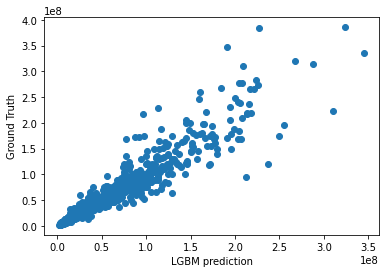

In [219]:
plt.scatter(lgbm_prediction, y_test)
plt.xlabel('LGBM prediction')
plt.ylabel('Ground Truth')

## Submission lgbm

In [220]:
lgb_prediction = np.exp(gbm6.predict(test_labels))
df = pd.DataFrame(lgb_prediction, columns = ['price_prediction'])
test.rename(columns={'apartment_id' : 'id'}, inplace=True)
result = pd.concat([test['id'], df], axis=1)
result = result.sort_values(by='id')
result[['id','price_prediction']].to_csv('.\submissions\LGBM2.0.csv', index=False)

# Actual Cross Validation

In [36]:
%%capture --no-display
X_train, y_train, test_labels = pre_process_numerical(features = all_features, numerical_features = numerical_features, train = train, test = test,
                    outliers_value=7, val_data=False, val_split=0.0, random_state=42, scaler="std",
                         add_R="True", add_rel_height="True", droptable=[],
                    one_hot_encode=True, cat_features=categorical, drop_old=True)

y_train_log = np.log(y_train)
trainDataLog = pd.concat([X_train, y_train_log],axis=1)

## Normal KFold

In [38]:
%%capture --no-display
numberSplits = 5
scores = []

model = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

kf = KFold(n_splits=numberSplits, shuffle=True)

for train_index, test_index in kf.split(trainDataLog):
    X_train, X_test = trainDataLog.iloc[train_index].drop('price', axis=1), trainDataLog.iloc[test_index].drop('price', axis=1)
    y_train, y_test = trainDataLog.iloc[train_index]['price'], trainDataLog.iloc[test_index]['price']
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=custom_asymmetric_eval,
        verbose=False,
    )    
    prediction = np.exp(model.predict(X_test))
    scores.append(root_mean_squared_log_error(prediction, np.exp(y_test)))
print("scores: ", scores)
print("average score: ", np.average(scores))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
scores:  [0.13425254321104668, 0.1213167578775224, 0.1335170354354575, 0.12140162852772553, 0.12950561578450467]
average score:  0.12799871616725136


## Stratified KFold Does Not Work

In [40]:
# %%capture --no-display
# X_train, y_train, test_labels = pre_process_numerical(features = all_features, numerical_features = numerical_features, train = train, test = test,
#                     outliers_value=7, val_data=False, val_split=0.0, random_state=42, scaler="std",
#                     add_R="True", add_rel_height="True", droptable=[],
#                     one_hot_encode=True, cat_features=categorical, drop_old=True)

# y_train_log = np.log(y_train)
# trainDataLog = pd.concat([X_train, y_train_log],axis=1)

In [44]:
# numberSplits = 5
# scores = []

# model = lightgbm.LGBMRegressor(random_state=33,
#                               early_stopping_rounds = 10,
#                               n_estimators=10000
#                              )

# skf = StratifiedKFold(n_splits=numberSplits, shuffle=True)

# for index, train_index, test_index in enumerate(skf.split(X_train, y_train_log)):
#     X_train, X_test = X_train.iloc[train_index].drop('price', axis=1), X_train.iloc[test_index].drop('price', axis=1)
#     y_train, y_test = y_train_log.iloc[train_index]['price'], y_train_log.iloc[test_index]['price']
#     model.fit(
#         X_train,
#         y_train,
#         eval_set=[(X_test, y_test)],
#         eval_metric=custom_asymmetric_eval,
#         verbose=False,
#     )    
#     prediction = np.exp(model.predict(X_test))
#     scores.append(root_mean_squared_log_error(prediction, np.exp(y_test)))
# print("scores: ", scores)
# print("average score: ", np.average(scores))

## Group KFold

In [9]:
%%capture --no-display
X_train, y_train, test_labels = pre_process_numerical(features = all_features, numerical_features = numerical_features, train = train, test = test,
                    outliers_value=7, val_data=False, val_split=0.0, random_state=42, scaler="std",
                    add_R="True", add_rel_height="True", droptable=[],
                    one_hot_encode=True, cat_features=categorical, drop_old=True)

y_train_log = np.log(y_train)
trainDataLog = pd.concat([X_train, y_train_log],axis=1)

In [10]:
%%capture --no-display
numberSplits = 10
current_model = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             ) 
scores, average_score, best_model, best_index = lgbm_groupKFold(number_of_splits=numberSplits,
                                        model=current_model,
                                        X_train=X_train, 
                                        y_train=y_train_log,
                                        eval_metric='neg_root_mean_squared_error')


In [11]:
print("scores: ", scores)
print("average score: ", average_score)
print("best model: ", best_model)
print("best index: ", best_index)

scores:  [0.19513408643558486, 0.16967795783418368, 0.18612551830939061, 0.24913092712346202, 0.19700096737521117, 0.19691017568868116, 0.2698351433344428, 0.1815176825278489, 0.1970092841549204, 0.1868077884625261]
average score:  0.20291495312462518
best model:  LGBMRegressor(early_stopping_rounds=10, n_estimators=10000, random_state=33)
best index:  1


In [12]:
predict_and_store(best_model, test_labels, test_labels, path=".\submissions\LGBM3.1.csv", exponential=True)